In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
#https://colab.research.google.com/github/dlmacedo/starter-academic/blob/master/content/courses/deeplearning/notebooks/pytorch/Time_Series_Prediction_with_LSTM_Using_PyTorch.ipynb#scrollTo=a2vvHeFgVtCp

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import subprocess
import time
import pyautogui
import pygetwindow as gw


In [2]:
from source.IB_connector import retrive_market_data

ticker = "AAPL"
training_set_aapl = retrive_market_data([ticker], duration = "9 m", time_interval = "15 mins")
training_set = training_set_aapl[ticker]
training_set['Volume'] = training_set['Volume'].astype(float)
training_set['Date'] = pd.to_datetime(training_set['Date'].str.replace(' US/Eastern',''),format="%Y%m%d %H:%M:%S")

Found window with title: Login
Found window with title: DUK343627 Interactive Brokers (Simulated Trading)


ERROR -1 2104 Market data farm connection is OK:usfarm.nj
ERROR -1 2104 Market data farm connection is OK:cashfarm
ERROR -1 2104 Market data farm connection is OK:usfarm
ERROR -1 2106 HMDS data farm connection is OK:ushmds
ERROR -1 2158 Sec-def data farm connection is OK:secdefil


In [3]:
training_set.head()

,Date,Open,High,Low,Close,Volume
0,2024-09-09 09:30:00,220.06,220.50,217.06,217.28,3987644.0
1,2024-09-09 09:45:00,217.28,218.88,217.07,218.47,2693052.0
2,2024-09-09 10:00:00,218.43,219.43,218.36,219.12,1599258.0
3,2024-09-09 10:15:00,219.11,219.21,217.97,218.11,1598926.0
4,2024-09-09 10:30:00,218.11,218.11,217.09,217.32,1605221.0


In [4]:
col_select = ['Open','High','Low','Close','Volume']
training_set = training_set[col_select]
training_set.dtypes
CLOSE_INDEX = col_select.index('Close')

In [5]:
n = len(training_set)
train_df = training_set[0:int(n*0.4)]
val_df = training_set[int(n*0.4):int(n*0.5)]
rl_df = training_set[int(n*0.5):int(n*0.9)]
test_df = training_set[int(n*0.9):]

In [6]:
train_mean = train_df.mean()
train_std = train_df.std()

In [7]:
train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std


In [8]:
from torch.utils.data import Dataset, DataLoader
from source.LSTMdataset import WindowDataset, WindowGenerator

OUT_STEPS = 16


w1 = WindowGenerator(input_width=48, label_width=OUT_STEPS, shift=OUT_STEPS, 
                    train_df=train_df, val_df=val_df, test_df=test_df, 
                    label_columns=['Close'])
# Stworzenie datasetu:
train_dataset = w1.make_dataset(train_df.values)  # Zakładając, że train_df to np. pandas.DataFrame
val_dataset = w1.make_dataset(val_df.values)  # Zakładając, że train_df to np. pandas.DataFrame

# DataLoader:
BATCH_SIZE = 512 # 256 * 2 = 512
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [9]:
from LSTMmodel import MultiLSTMModel, MAPELoss
num_epochs = 2000
learning_rate = 0.014

num_features = 5
input_size = num_features
lstm = MultiLSTMModel(input_size=input_size, lstm_units=32, out_steps=OUT_STEPS, num_features=num_features)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm.to(device)

MultiLSTMModel(
  (lstm): LSTM(5, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
)

In [10]:
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
criterion = MAPELoss()

for epoch in range(num_epochs):
  
    for inputs, labels in train_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = lstm(inputs)
      optimizer.zero_grad()
      loss = criterion(outputs, labels)
      
      loss.backward()
      
      optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))



Epoch: 0, loss: 202.33043
Epoch: 100, loss: 65.59538
Epoch: 200, loss: 49.89587
Epoch: 300, loss: 30.79297
Epoch: 400, loss: 48.92028
Epoch: 500, loss: 57.94100
Epoch: 600, loss: 34.33714
Epoch: 700, loss: 66.52834
Epoch: 800, loss: 25.12181
Epoch: 900, loss: 36.34545
Epoch: 1000, loss: 63.31198
Epoch: 1100, loss: 63.48962
Epoch: 1200, loss: 38.92329
Epoch: 1300, loss: 26.95537
Epoch: 1400, loss: 39.18861
Epoch: 1500, loss: 36.93542
Epoch: 1600, loss: 32.32540
Epoch: 1700, loss: 55.68192
Epoch: 1800, loss: 55.13956
Epoch: 1900, loss: 46.26508


In [11]:
#torch.save(lstm.state_dict(), 'appl_15min_8m_LSTM.pth')

In [12]:
i = 0 
for inputs, labels in val_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = lstm(inputs)
    
    loss = criterion(outputs, labels)    
    leb = labels.detach().cpu().numpy()*train_std[3] + train_mean[3]
    pred = outputs.detach().cpu().numpy()*train_std[3] + train_mean[3]
    print(loss.item())
    print("MAPE ", np.mean(np.abs(leb - pred) / leb * 100) )
    print("MAE ", np.mean(np.abs(leb - pred)) )


131.25013732910156
MAPE  1.1171594
MAE  2.6599364


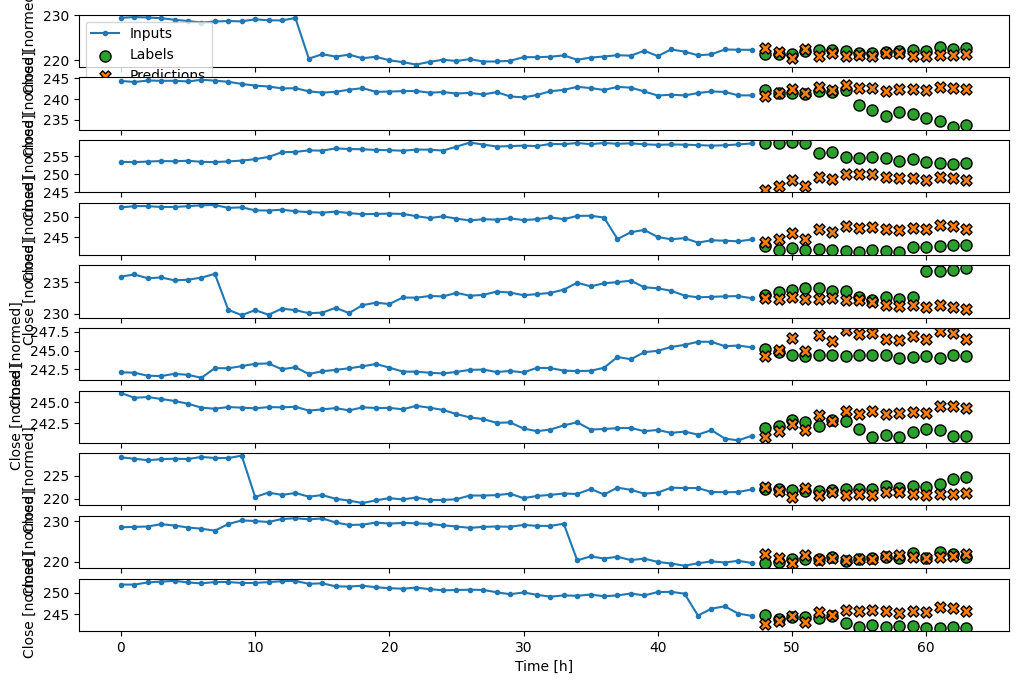

In [13]:
inpu = inputs.detach().cpu().numpy()*train_std[CLOSE_INDEX] + train_mean[CLOSE_INDEX]

w1.example = inpu, leb

w1.plot(pred, max_subplots=10)

In [49]:
import numpy as np
import gym
from gymnasium import spaces
import torch

class TimeSeriesEnvFuturePredict_VEC(gym.Env):
    def __init__(self, data, lstm, lstm_data, train_std, train_mean, device, window_size=10, future_size=16):
        self.data = data.astype(np.float32)
        self.window_size = window_size
        self.future_size = future_size
        self.current_step = window_size
        self.device = device
        self.lstm = lstm
        self.lstm_data = lstm_data.astype(np.float32)
        self.train_std = float(train_std)
        self.train_mean = float(train_mean)

        self.action_space = spaces.Discrete(3)  # 0 = hold, 1 = buy, 2 = sell
        self.observation_space = spaces.Box(
            low=-50, high=50, shape=(window_size + future_size,), dtype=np.float32
        )

        self.inventory = []
        self.total_profit = 0.0
        self.states_buy = []
        self.states_sell = []

    def reset(self, *, seed=None, options=None):
        self.current_step = self.window_size
        self.inventory = []
        self.total_profit = 0.0
        self.states_buy = []
        self.states_sell = []

        if self.current_step >= len(self.data):
            raise ValueError("Dane są zbyt krótkie, by zobaczyć przyszłe punkty.")

        return self._get_observation(), {}

    def _get_observation(self):
        past = self.data[self.current_step - self.window_size:self.current_step]
        past_lstm = self.lstm_data[self.current_step - self.window_size:self.current_step].astype(np.float32)

        inputs = torch.from_numpy(past_lstm.astype(np.float32)).float().to(self.device)
        outputs = self.lstm(inputs)
        future = outputs.detach().cpu().numpy().flatten().astype(np.float32)

        past = (past - self.train_mean) / self.train_std
        obs = np.concatenate([past, future])
        return np.round(obs.astype(np.float32), 3)

    def step(self, action):
        terminated = False
        truncated = False
        reward = 0.0
        price = self.data[self.current_step]

        if action == 1:  # Buy
            self.inventory.append(price)
            self.states_buy.append(self.current_step)

        elif action == 2 and len(self.inventory) > 0:  # Sell
            bought_price = self.inventory.pop(0)
            profit = price - bought_price
            reward = profit
            self.total_profit += profit
            self.states_sell.append(self.current_step)

        self.current_step += 1

        if self.current_step >= len(self.data):
            terminated = True
            if len(self.inventory) > 0:
                self.total_profit += np.sum(self.data[-1] - np.array(self.inventory, dtype=np.float32))

        return self._get_observation(), reward, terminated, truncated, {}


In [ ]:
#from enviroments import TimeSeriesEnvFuturePredict, TimeSeriesEnv
env = TimeSeriesEnvFuturePredict_VEC(data=rl_df['Close'].values, lstm=lstm,lstm_data=rl_df.values,device=device,
                                  train_std = train_std[CLOSE_INDEX],train_mean= train_mean[CLOSE_INDEX], window_size=48, future_size=OUT_STEPS)

#env = TimeSeriesEnv(rl_df['Close'].values, 96)

In [ ]:
from gymnasium.vector import AsyncVectorEnv
def make_env(data, lstm, lstm_data, device, train_std, train_mean, window_size, future_size):
    def thunk():
        return TimeSeriesEnvFuturePredict_VEC(
            data=data, 
            lstm=lstm, 
            lstm_data=lstm_data, 
            device=device,
            train_std=train_std, 
            train_mean=train_mean, 
            window_size=window_size, 
            future_size=future_size
        )
    return thunk

NUM_ENVS = 8
# envs = AsyncVectorEnv([make_env(data=rl_df['Close'].values, lstm=lstm,lstm_data=rl_df.values,device=device,
#                                   train_std = train_std[CLOSE_INDEX],train_mean= train_mean[CLOSE_INDEX], window_size=48, future_size=OUT_STEPS) for _ in range(NUM_ENVS)])
env_fns = [
            make_env(
                data=rl_df['Close'].values, 
                lstm=lstm,
                lstm_data=rl_df.values,
                device=device,
                train_std=float(train_std[CLOSE_INDEX]),
                train_mean=float(train_mean[CLOSE_INDEX]), 
                window_size=48, 
                future_size=OUT_STEPS
            ) for _ in range(NUM_ENVS)
        ] 

envs = AsyncVectorEnv(env_fns)

states, _ = envs.reset()

In [17]:
from rl_agent import DQNAgent, train_episode, train_parallel_episode

agent = DQNAgent(observation_space=env.observation_space.shape[0], action_space=env.action_space.n)

In [18]:
from tqdm import tqdm

epsilon = 1
EPISODES = 102
# Iterate over episodes
for episode in tqdm(range(1, EPISODES + 1), ascii=True, unit='episodes'):
    train_parallel_episode(agent, envs, episode, epsilon,NUM_ENVS)
    #train_episode(agent,env, episode, 0.9)



  0%|          | 0/102 [00:00<?, ?episodes/s]

 98%|#########8| 100/102 [30:27<00:35, 17.77s/episodes]

Episode: 100 Avg Reward: -443.96 Epsilon: 1.000


100%|##########| 102/102 [31:00<00:00, 18.24s/episodes]


In [19]:
from rl_agent import save_dqn_agent

save_dqn_agent(agent, 'aapl_15min_norm_8env_newEpsilon.pth')

In [ ]:
ticker = "AAPL"
other_ticker = retrive_market_data([ticker], duration = "1 M", time_interval = "15 mins")
other_ticker = other_ticker[ticker]
other_ticker['Volume'] = other_ticker['Volume'].astype(float)
other_ticker['Date'] = pd.to_datetime(other_ticker['Date'].str.replace(' US/Eastern',''),format="%Y%m%d %H:%M:%S")
other_ticker = other_ticker[col_select]
#other_ticker = (other_ticker - other_ticker.mean()) / other_ticker.std()


ERROR -1 2104 Market data farm connection is OK:usfarm.nj
ERROR -1 2104 Market data farm connection is OK:cashfarm
ERROR -1 2104 Market data farm connection is OK:usfarm
ERROR -1 2106 HMDS data farm connection is OK:ushmds
ERROR -1 2158 Sec-def data farm connection is OK:secdefil


Found window with title: DUK343627 Interactive Brokers (Simulated Trading)


In [50]:
test_env = TimeSeriesEnvFuturePredict_VEC(data=test_df['Close'].values, lstm=lstm,lstm_data=test_df.values,device=device,
                                 train_std = train_std[CLOSE_INDEX],train_mean= train_mean[CLOSE_INDEX], window_size=48, future_size=OUT_STEPS)

# test_env = TimeSeriesEnvFuturePredict_VEC(
#                 data=rl_df['Close'].values, 
#                 lstm=lstm,
#                 lstm_data=rl_df.values,
#                 device=device,
#                 train_std=float(train_std[CLOSE_INDEX]),
#                 train_mean=float(train_mean[CLOSE_INDEX]), 
#                 window_size=48, 
#                 future_size=OUT_STEPS)


In [51]:
# test_env = TimeSeriesEnvFuturePredict_VEC(data=other_ticker['Close'].values, lstm=lstm,lstm_data=other_ticker.values,device=device,
#                                  train_std = other_ticker.std()[CLOSE_INDEX],train_mean= other_ticker.mean()[CLOSE_INDEX], window_size=48, future_size=OUT_STEPS)

In [52]:
test_env._get_observation()

array([-3.369e+00, -3.509e+00, -3.538e+00, -3.506e+00, -3.452e+00,
       -3.501e+00, -3.490e+00, -3.466e+00, -3.497e+00, -3.532e+00,
       -3.558e+00, -3.550e+00, -3.541e+00, -3.532e+00, -3.498e+00,
       -3.471e+00, -3.442e+00, -3.448e+00, -3.455e+00, -3.448e+00,
       -3.430e+00, -3.464e+00, -3.473e+00, -3.489e+00, -2.513e+00,
       -2.391e+00, -2.250e+00, -2.324e+00, -2.259e+00, -2.328e+00,
       -2.414e+00, -2.367e+00, -2.385e+00, -2.402e+00, -2.367e+00,
       -2.370e+00, -2.317e+00, -2.316e+00, -2.246e+00, -2.240e+00,
       -2.209e+00, -2.167e+00, -2.167e+00, -2.151e+00, -2.130e+00,
       -2.167e+00, -2.176e+00, -2.228e+00,  2.400e-02, -3.000e-03,
       -2.300e-02,  7.000e-03, -6.700e-02, -4.500e-02, -2.600e-02,
       -1.000e-02, -2.600e-02, -1.300e-02,  1.290e-01,  1.630e-01,
        1.910e-01,  2.190e-01,  2.230e-01,  2.080e-01], dtype=float32)

In [53]:
def evaluate_steps_vec(env, model, device="cuda:0"):
    state,_ = env.reset()
    total_reward = 0
    done = False
    steps = 0
    action = 0
    while not done:
        # konwersja stanu na tensora
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

        with torch.no_grad():
            q_values = model(state_tensor)
            action = torch.argmax(q_values).item()

        state, reward, done, truncated, infos = env.step(action)
        total_reward += reward
        steps += 1
        #print(f"Krok: {steps}, Akcja: {action}, Nagroda: {reward:.2f}, Łączny zysk: {env.total_profit:.2f}")

    #print(state_tensor)
    return total_reward



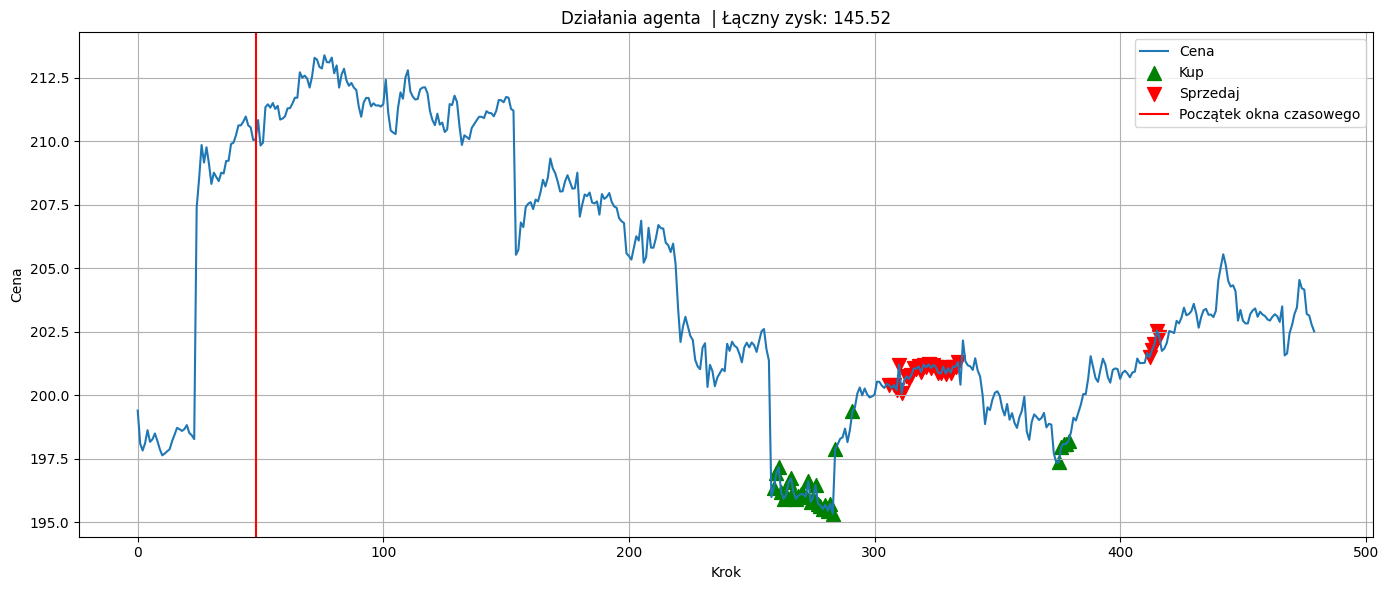

In [54]:
from eval_models import evaluate_steps, render_env

test_env.reset()
#evaluate_steps(test_env, agent.target_model)
evaluate_steps_vec(test_env, agent.target_model, device=device)
render_env(test_env, title_suffix="")

In [55]:
sum(test_env.inventory) - len(test_env.inventory) * test_env.data[-1]

0.0

In [56]:
np.sum(test_env.data[-1] - test_env.inventory) 

0.0

In [57]:
test_env.data[-1]

202.52

In [58]:
test_env.inventory

[]